In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.all import (Adder, AddMultibodyPlantSceneGraph, Demultiplexer,
                         DiagramBuilder, InverseDynamicsController,
                         MakeMultibodyStateToWsgStateSystem, MeshcatVisualizer,
                         MultibodyPlant, Parser, PassThrough, RigidTransform,
                         RollPitchYaw, SchunkWsgPositionController,
                         StartMeshcat, StateInterpolatorWithDiscreteDerivative)

from manipulation import running_as_notebook
from manipulation.scenarios import (AddCameraBox, AddIiwa, AddRgbdSensors,
                                    AddWsg)
from manipulation.utils import FindResource


In [3]:
# Start the visualizer.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


# Set up a basic ManipulationStation diagram

Completely in pydrake.  Feel free to modify it as you see fit.  You might also look at the [C++ version](https://github.com/RobotLocomotion/drake/blob/master/examples/manipulation_station/manipulation_station.cc#L193) if you want inspiration for tables / cupboards / bins, etc that you might add.  Here is [a link to the scenarios file](https://github.com/RussTedrake/manipulation/blob/master/manipulation/scenarios.py), in case you need to modify `AddIiwa` and friends.

In [8]:
def MakeManipulationStation(time_step=0.002):
    builder = DiagramBuilder()

    # Add (only) the iiwa, WSG, and cameras to the scene.
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step=time_step)
    iiwa = AddIiwa(plant)
    wsg = AddWsg(plant, iiwa)
    X_WC = RigidTransform(RollPitchYaw(-5 * np.pi / 8, 0, 0), [0.25, -1.5, 1])
    AddCameraBox(plant, X_WC, "camera0")
    plant.Finalize()

    num_iiwa_positions = plant.num_positions(iiwa)

    # I need a PassThrough system so that I can export the input port.
    iiwa_position = builder.AddSystem(PassThrough(num_iiwa_positions))
    builder.ExportInput(iiwa_position.get_input_port(), "iiwa_position")
    builder.ExportOutput(iiwa_position.get_output_port(), "iiwa_position_command")

    # Export the iiwa "state" outputs.
    demux = builder.AddSystem(Demultiplexer(
        2 * num_iiwa_positions, num_iiwa_positions))
    builder.Connect(plant.get_state_output_port(iiwa), demux.get_input_port())
    builder.ExportOutput(demux.get_output_port(0), "iiwa_position_measured")
    builder.ExportOutput(demux.get_output_port(1), "iiwa_velocity_estimated")
    builder.ExportOutput(plant.get_state_output_port(iiwa), "iiwa_state_estimated")

    # Make the plant for the iiwa controller to use.
    controller_plant = MultibodyPlant(time_step=time_step)
    controller_iiwa = AddIiwa(controller_plant)
    AddWsg(controller_plant, controller_iiwa, welded=True)
    controller_plant.Finalize()

    # Add the iiwa controller
    iiwa_controller = builder.AddSystem(
        InverseDynamicsController(
            controller_plant,
            kp=[100]*num_iiwa_positions,
            ki=[1]*num_iiwa_positions,
            kd=[20]*num_iiwa_positions,
            has_reference_acceleration=False))
    iiwa_controller.set_name("iiwa_controller")
    builder.Connect(
        plant.get_state_output_port(iiwa), iiwa_controller.get_input_port_estimated_state())

    # Add in the feed-forward torque
    adder = builder.AddSystem(Adder(2, num_iiwa_positions))
    builder.Connect(iiwa_controller.get_output_port_control(),
                    adder.get_input_port(0))
    # Use a PassThrough to make the port optional (it will provide zero values if not connected).
    torque_passthrough = builder.AddSystem(PassThrough([0]*num_iiwa_positions))
    builder.Connect(torque_passthrough.get_output_port(),
                    adder.get_input_port(1))
    builder.ExportInput(torque_passthrough.get_input_port(),
                        "iiwa_feedforward_torque")
    builder.Connect(adder.get_output_port(),
                    plant.get_actuation_input_port(iiwa))

    # Add discrete derivative to command velocities.
    desired_state_from_position = builder.AddSystem(
        StateInterpolatorWithDiscreteDerivative(
            num_iiwa_positions, time_step, suppress_initial_transient=True))
    desired_state_from_position.set_name("desired_state_from_position")
    builder.Connect(desired_state_from_position.get_output_port(),
                    iiwa_controller.get_input_port_desired_state())
    builder.Connect(iiwa_position.get_output_port(),
                    desired_state_from_position.get_input_port())

    # Export commanded torques.
    builder.ExportOutput(adder.get_output_port(), "iiwa_torque_commanded")
    builder.ExportOutput(adder.get_output_port(), "iiwa_torque_measured")

    builder.ExportOutput(plant.get_generalized_contact_forces_output_port(iiwa),
                         "iiwa_torque_external")

    # Wsg controller.
    wsg_controller = builder.AddSystem(SchunkWsgPositionController())
    wsg_controller.set_name("wsg_controller")
    builder.Connect(
        wsg_controller.get_generalized_force_output_port(),
        plant.get_actuation_input_port(wsg))
    builder.Connect(plant.get_state_output_port(wsg),
                    wsg_controller.get_state_input_port())
    builder.ExportInput(wsg_controller.get_desired_position_input_port(),
                        "wsg_position")
    builder.ExportInput(wsg_controller.get_force_limit_input_port(),
                        "wsg_force_limit")
    wsg_mbp_state_to_wsg_state = builder.AddSystem(
        MakeMultibodyStateToWsgStateSystem())
    builder.Connect(plant.get_state_output_port(wsg),
                    wsg_mbp_state_to_wsg_state.get_input_port())
    builder.ExportOutput(wsg_mbp_state_to_wsg_state.get_output_port(),
                         "wsg_state_measured")
    builder.ExportOutput(wsg_controller.get_grip_force_output_port(),
                         "wsg_force_measured")

    # Cameras.
    AddRgbdSensors(builder, plant, scene_graph)

    # Export "cheat" ports.
    builder.ExportOutput(scene_graph.get_query_output_port(), "geometry_query")
    builder.ExportOutput(plant.get_contact_results_output_port(),
                         "contact_results")
    builder.ExportOutput(plant.get_state_output_port(),
                         "plant_continuous_state")

    diagram = builder.Build()
    return diagram


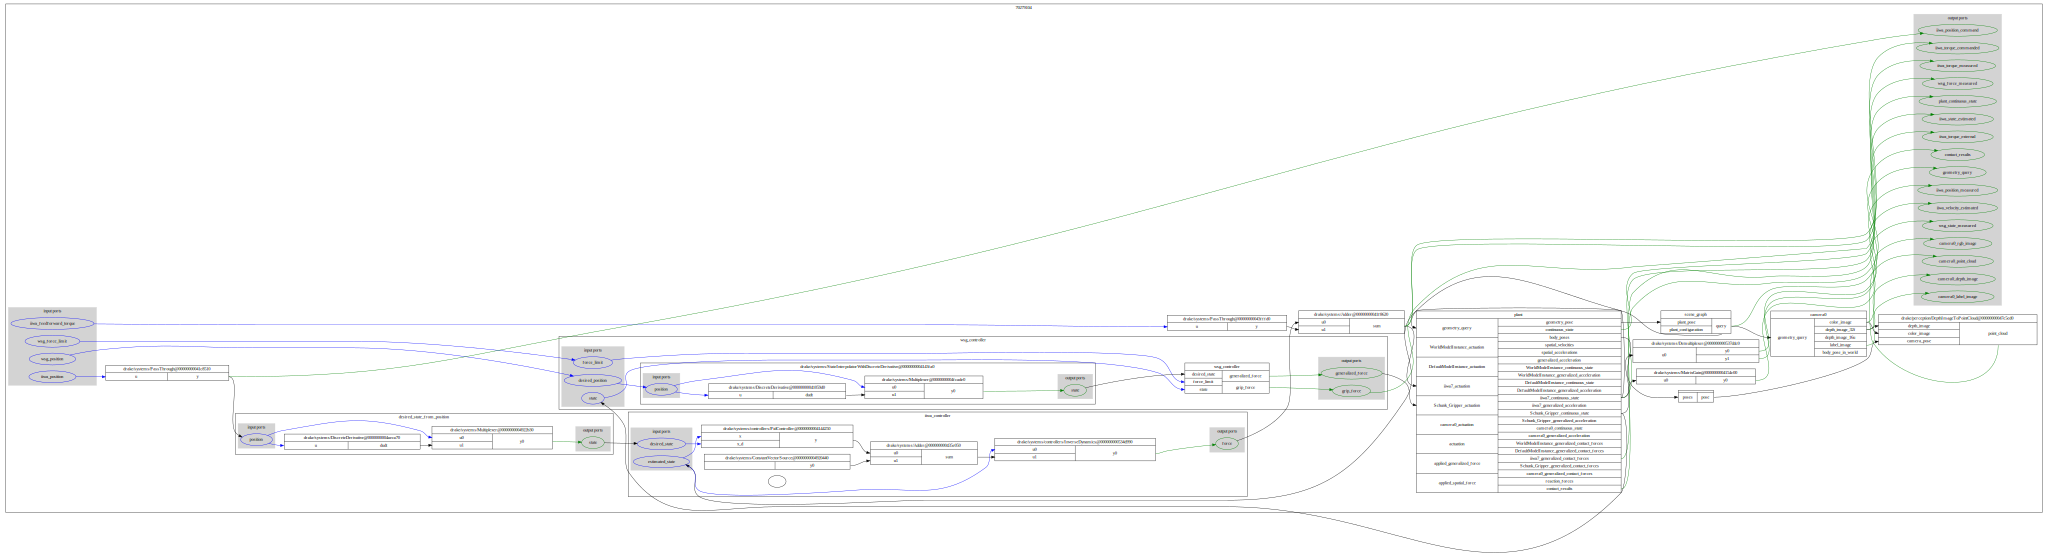

In [5]:
def DrawBlockDiagram():
    diagram = MakeManipulationStation()
    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

DrawBlockDiagram()

In [9]:
def TestWithMeshcat():
    builder = DiagramBuilder()
    station = builder.AddSystem(MakeManipulationStation())

    MeshcatVisualizer.AddToBuilder(
        builder, station.GetOutputPort("geometry_query"), meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

TestWithMeshcat()

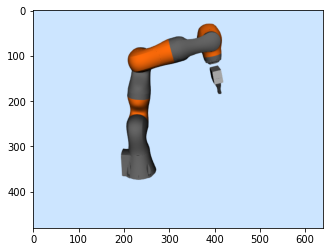

In [10]:
def TestCamera():
    station = MakeManipulationStation()
    context = station.CreateDefaultContext()
    image = station.GetOutputPort("camera0_rgb_image").Eval(
        context).data[:, :, :3]
    fig, ax = plt.subplots()
    ax.imshow(image)

TestCamera()
